# 3.1 Part A: Implementing Convolutional Neural Network from scratch.

## 3.1.1. Data Understanding, Analysis, Visualization and Cleaning [3].

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [320]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Activation, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3

In [365]:
# Path to the train and test dataset
train_folder = "C:\\Users\\NILEENA\\Desktop\\AI and ML\\Scene Classification\\train"
test_folder = "C:\\Users\\NILEENA\\Desktop\\AI and ML\\Scene Classification\\test"

# Get the list of class directories
class_names = sorted(os.listdir(train_folder))

if not class_names:
    print("No class directories found in the train folder!")
else:
    print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## • What does the dataset represent? Provide a brief description.

Ans:

The dataset is about Scene Classification. It consists of images of six distinct classes : Buildings, Forest, Glacier, Mountain, Sea, and Street. The dataset is used for training and testing an image classification model to recognize types of scenes. All the images in the dataset are in JPEG format with a resolution of 150*150 pixels.

In [114]:
# Function to count images per class
def count_images_per_class(folder_path):
    image_count_per_class = {}
    total_images = 0
    
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            count = len(image_files)
            image_count_per_class[class_folder] = count
            total_images += count
    
    return image_count_per_class, total_images

# Count images in both train and test sets
train_counts, train_total = count_images_per_class(train_folder)
test_counts, test_total = count_images_per_class(test_folder)

print("\nImage counts:")
print("=============")
print(f"Training images: {train_total}")
print(f"Test images: {test_total}")
print(f"Total dataset size: {train_total + test_total}\n")

print("Training set distribution:")
print("=========================")
for cls, count in train_counts.items():
    print(f"{cls}: {count}")


Image counts:
Training images: 13992
Test images: 3000
Total dataset size: 16992

Training set distribution:
buildings: 2184
forest: 2264
glacier: 2397
mountain: 2505
sea: 2267
street: 2375


## • How many total images are in the dataset?

Ans:

The dataset contains 16,992 images in total (13,992 for training, 3,000 for testing).

## • What is the distribution of images across different classes?

Ans:

The distribution of images across different classes are provided below:

i) Buildings: 2,184

ii) Forest: 2,264

iii) Glacier: 2,397

iv) Mountain: 2,505

v) Sea: 2,267

vi) Street: 2,375

## • How is the dataset split into training and validation sets? Justify your choice.

Ans:

The dataset is split into 80% training and 20% validation. This split ensures that each class is proportionally represented in both sets by maintaining balance and preventing biased evaluation. Moreover, this ratio is commonly adopted practice in machine learning tasks, since it provides the model with sufficient data for learning patterns during training, while also allowing for reliable performance evaluation on unseen data in the validation set. 

In [66]:
# Function to find corrupt images in each class directory
def find_corrupt_images_per_class(folder_path):
    corrupt_images = []
    corrupt_count_per_class = {}

    # Loop through each class folder inside the main folder
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            class_corrupt_count = 0
            # Loop through each image file in the class folder
            for filename in os.listdir(class_path):
                file_path = os.path.join(class_path, filename)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Check if image is not corrupted
                except (UnidentifiedImageError, IOError, SyntaxError):
                    corrupt_images.append(file_path)
                    class_corrupt_count += 1
            if class_corrupt_count > 0:
                corrupt_count_per_class[class_folder] = class_corrupt_count

    return corrupt_images, corrupt_count_per_class

# Call the function and print results
corrupt_imgs, corrupt_per_class = find_corrupt_images_per_class(train_folder)

if len(corrupt_imgs) > 0:
    print(f"\nTotal corrupt images found: {len(corrupt_imgs)}")
    print("=" * 40)
    print("Corrupt images per class:")
    print("=" * 40)
    for cls, count in corrupt_per_class.items():
        print(f"{cls}: {count}")
else:
    print("No corrupt images found in any class.")

No corrupt images found in any class.


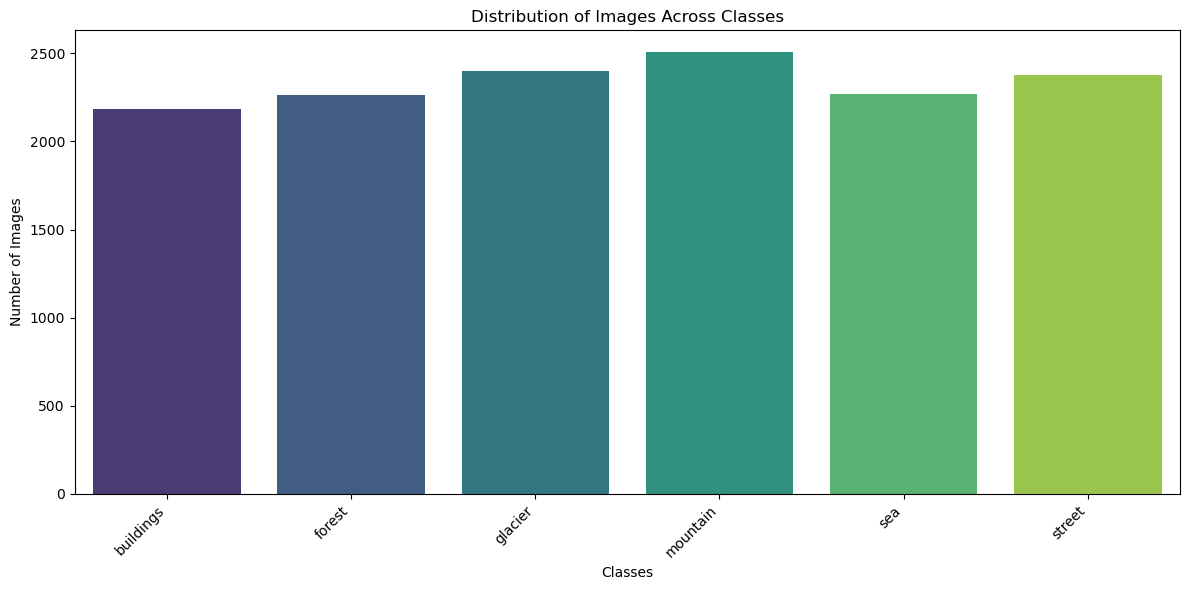

In [76]:
# Define the function to plot the image distribution
def plot_image_distribution(image_counts):
    df = pd.DataFrame(list(image_counts.items()), columns=["Class", "Image Count"])
    plt.figure(figsize=(12, 6))

    # Create a bar plot using Seaborn
    sns.barplot(data=df, x="Class", y="Image Count", hue="Class", palette="viridis", legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title("Distribution of Images Across Classes")
    plt.tight_layout()
    plt.show()

# Call the function, passing the 'train_counts' dictionary as the argument
plot_image_distribution(train_counts)

## • What preprocessing techniques (e.g., resizing, normalization) were applied?

Ans:

The following preprocessing techniques were applied to the dataset:

i) Resizing: The images are resized to a consistent shape of 128*128 pixels using the 'image_size=(128, 128) parameter in 'image_dataset_from_directory'. This ensures that all images have the same dimensions and are ready for input into the neural network

ii) Normalization: The pixel values of the images are normalized to the range [0,1] by applying a 'Rescaling' layer with the factor '1/255'. This helps in speeding up the training and improving the model's convergence, as neural networks generally perform better when input features are scaled.

iii) Data Augmentation: Various data augmentation techniques are applied during training to improve the generalization and reduce overfitting of the model:

a) Random Horizontal Flip

b) Random Rotation

c) Random Zoom

d) Random Height & Width Changes

e) Random Translation

## • What data generators, if any, were used for preprocessing and augmentation?

Ans:

We used TensorFlow's 'image_dataset_from_directory()' function (new API) to load images efficiently from directories. For preprocessing and augmentation, we applied a sequential block of data augmentation layers such as RandomFlip, RandomRotation, RandomZone, etc., followed by a 'Rescalling' layer to normalize pixel values between 0 and 1. These transformations were applied to the training data using the '.map()' method, allowing the model to receive augmented and normalized images dynamically during training.

## • If data augmentation was applied, provide visualizations of sample augmented images.

Ans:

Yes, data augmentation was applied. Below is a visualization showing 1 original image followed by 8 augmented versions of the same image using TensorFlow's new Keras preprocessing layers.

Found 13992 files belonging to 6 classes.
Using 11194 files for training.


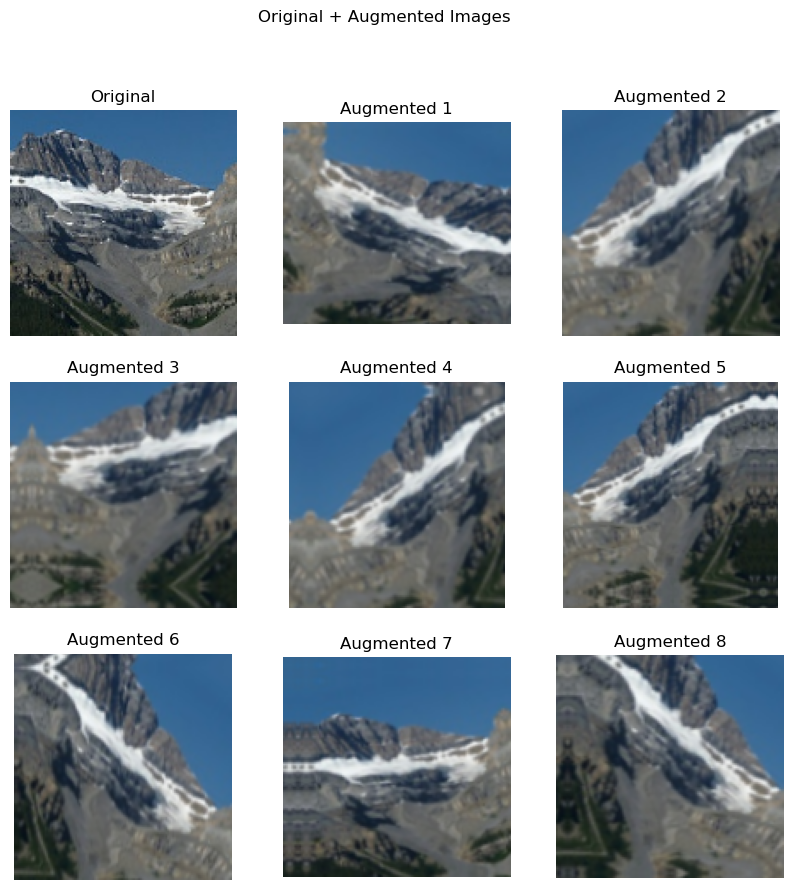

In [48]:
# Define image dimensions and batch size
img_height = 128
img_width = 128
batch_size = 32
seed = 123              # Seed for reproducibility
validation_split = 0.2  # 20% of data used for validation

# Data augmentation block
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomHeight(0.1),
    layers.RandomWidth(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

# Load a small subset of the training dataset (without any augmentation)
sample_ds = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=1,  # Load one image per batch to visualize clearly
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=seed
)

# Extract one batch (1 image) from the training dataset and show augmented versions
for image_batch, label_batch in sample_ds.take(1):
    image = image_batch[0]  # Get the first image
    image = tf.expand_dims(image, 0)  # Add batch dimension for augmentation

    plt.figure(figsize=(10, 10))

    # Show original image first
    plt.subplot(3, 3, 1)
    plt.imshow(tf.cast(image[0], tf.uint8).numpy())
    plt.axis('off')
    plt.title('Original')

    # Show 8 augmented images
    for i in range(1, 9):
        augmented_image = data_augmentation(image)  # Applies random transformations to the image
        augmented_image = tf.clip_by_value(augmented_image, 0, 255)  # Clip values
        img_np = tf.cast(augmented_image[0], tf.uint8).numpy()  # Convert to valid image
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f'Augmented {i}')
    plt.suptitle("Original + Augmented Images")
    plt.show()
    break

## 3.1.2 Design, Train, and Evaluate a Baseline Model

## 1: Model Architecture (Baseline CNN Model)

## • Build a baseline CNN model with the following structure:

– Three Convolutional layers, each followed by pooling layers.

– Three fully connected layers (FCN)

– An output layer suitable for classification.
## • Use an appropriate activation function and kernel size for each layer.
## • Print and analyze the model summary.

In [138]:
# Parameters
# Set image size for resizing all input images to a uniform shape
img_height = 128
img_width = 128
batch_size = 32           # Set batch size for training and validation datasets
validation_split = 0.2    # Use 20% of the dataset for validation, 80% for training
seed = 123                # Seed for reproducibility (ensures same split every time the code runs)

# Data augmentation layers to increase training data diversity
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1, fill_mode='constant'),
    layers.RandomTranslation(0.1, 0.1, fill_mode='constant')   # Translate images randomly (10% height/width)
])

# Load datasets 
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='both',
    seed=seed
)

# Apply augmentation only to training set
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Cache the dataset in memory/disk after the first epoch to speed up training
# Prefetch allows data loading and model training to overlap (improves efficiency)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Print class_names which we got earlier from os.listdir()
print("Class names being used:", class_names)

Found 13992 files belonging to 6 classes.
Using 11194 files for training.
Using 2798 files for validation.
Class names being used: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [259]:
# Define the baseline CNN model
baseline_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),   # Input layer specifying the shape of input images
    layers.Rescaling(1./255),                         # Normalization layer

    # 1st Convolutional Block with kernel size (3,3) and activation: 'relu'
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # 2nd Convolutional Block with kernel size (3,3) and activation: 'relu'
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # 3rd Convolutional Block with kernel size (3,3) and activation: 'relu'
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Flatten layer
    layers.Flatten(),

    # 1st Fully Connected Layer (Dense), Activation: 'relu'.
    layers.Dense(128, activation='relu'),

    # 2nd Fully Connected Layer (Dense). Activation: 'relu'.
    layers.Dense(64, activation='relu'),

    # 3rd Fully Connected Layer (Dense). Activation: 'relu'.
    layers.Dense(32, activation='relu'),
    layers.Dense(6, activation='softmax')  # Output Layer, 6 units for 6 classes
])

# Compile the model
baseline_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Print the model summary:
baseline_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_24 (Rescaling)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,315,174 (12.65 MB)

 Trainable params: 3,315,174 (12.65 MB)

 Non-trainable params: 0 (0.00 B)

## Analyzing the model summary

Ans:

The model summary provides a layer-by-layer breakdown of the network, including output shapes and the number of parameters. The baseline CNN model, accurately implements the required architecture with three convolutional blocks, three fully connected layers, and a softmax output layer for 6-class classification, totalling approximately 3.3 million parameters, the majority of which are found in the first dense layer.

## 2: Model Training

## • Train the baseline model for an appropriate number of epochs.

## • Plot the training vs validation loss curves over epochs.

In [264]:
# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n--- Training Baseline Model ---")
# Record the start time of training for the baseline model
start_time_baseline_original = time.time()

# Train the baseline model using the .fit() method
history_baseline = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

# Record the end time of training for the baseline model
end_time_baseline_original = time.time()

# Calculate the total training time for the baseline model
training_time_baseline_original = end_time_baseline_original - start_time_baseline_original
print(f"Original baseline model training time: {training_time_baseline_original:.2f} seconds "
      f"(trained for {len(history_baseline.history['loss'])} epochs)")


--- Training Baseline Model ---
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 116s 330ms/step - accuracy: 0.6253 - loss: 0.9608 - val_accuracy: 0.6655 - val_loss: 0.9227
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 104s 296ms/step - accuracy: 0.6815 - loss: 0.8476 - val_accuracy: 0.7227 - val_loss: 0.7963
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 107s 305ms/step - accuracy: 0.7319 - loss: 0.7244 - val_accuracy: 0.7244 - val_loss: 0.8162
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 108s 309ms/step - accuracy: 0.7692 - loss: 0.6279 - val_accuracy: 0.7073 - val_loss: 0.9410
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 112s 320ms/step - accuracy: 0.7969 - loss: 0.5580 - val_accuracy: 0.6741 - val_loss: 1.0922
Original baseline model training time: 546.88 seconds (trained for 5 epochs)


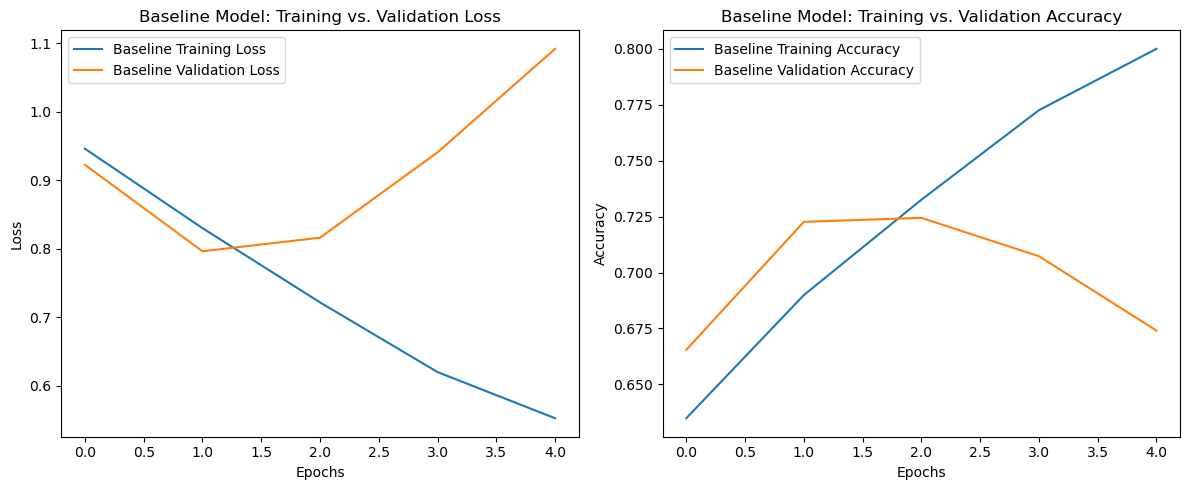

In [272]:
# Plotting Training History for Baseline Model 
# Plot training vs validation loss curves over epochs
plt.figure(figsize=(12, 5)) # Adjusted for potentially two plots

plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['loss'], label='Baseline Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Baseline Validation Loss')

# Set labels for the x-axis and y-axis
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the title for the plot
plt.title('Baseline Model: Training vs. Validation Loss')

# Display the legend to identify the lines
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['accuracy'], label='Baseline Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Baseline Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Baseline Model: Training vs. Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Model Evaluation

## • Evaluate the model using appropriate metrics (e.g. accuracy, precision, recall and F-1 score).

Validation Loss: 0.7963
Validation Accuracy: 0.7227

Classification Report:
              precision    recall  f1-score   support

   buildings       0.68      0.65      0.67       436
      forest       0.90      0.93      0.91       471
     glacier       0.72      0.59      0.65       465
    mountain       0.76      0.58      0.66       493
         sea       0.60      0.77      0.67       453
      street       0.70      0.82      0.76       480

    accuracy                           0.72      2798
   macro avg       0.73      0.72      0.72      2798
weighted avg       0.73      0.72      0.72      2798



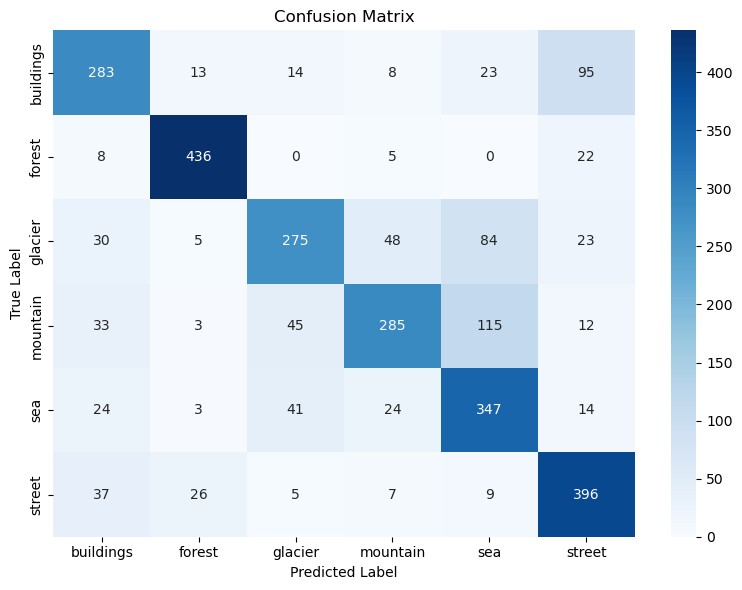

In [274]:
# Evaluate the trained baseline model on the validation dataset
val_loss, val_acc = baseline_model.evaluate(val_ds, verbose=0)  
print(f"Validation Loss: {val_loss:.4f}")        # Print validation loss 
print(f"Validation Accuracy: {val_acc:.4f}")     # Print validation accuracy 

# Initialize empty lists to store true and predicted class indices
y_true = []
y_pred = []

# Loop through each batch of images and labels in the validation set
for images, labels in val_ds:
    preds = baseline_model.predict(images, verbose=0)  # Predict the class probabilities for the batch
    y_true.extend(np.argmax(labels.numpy(), axis=1))   # Convert one-hot encoded true labels to class indices
    y_pred.extend(np.argmax(preds, axis=1))            # Get predicted class indices from model output

# Classification report with zero_division=0 to avoid warnings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix: rows = true labels, columns = predicted labels
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## • Perform inference on sample images and plot the result.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


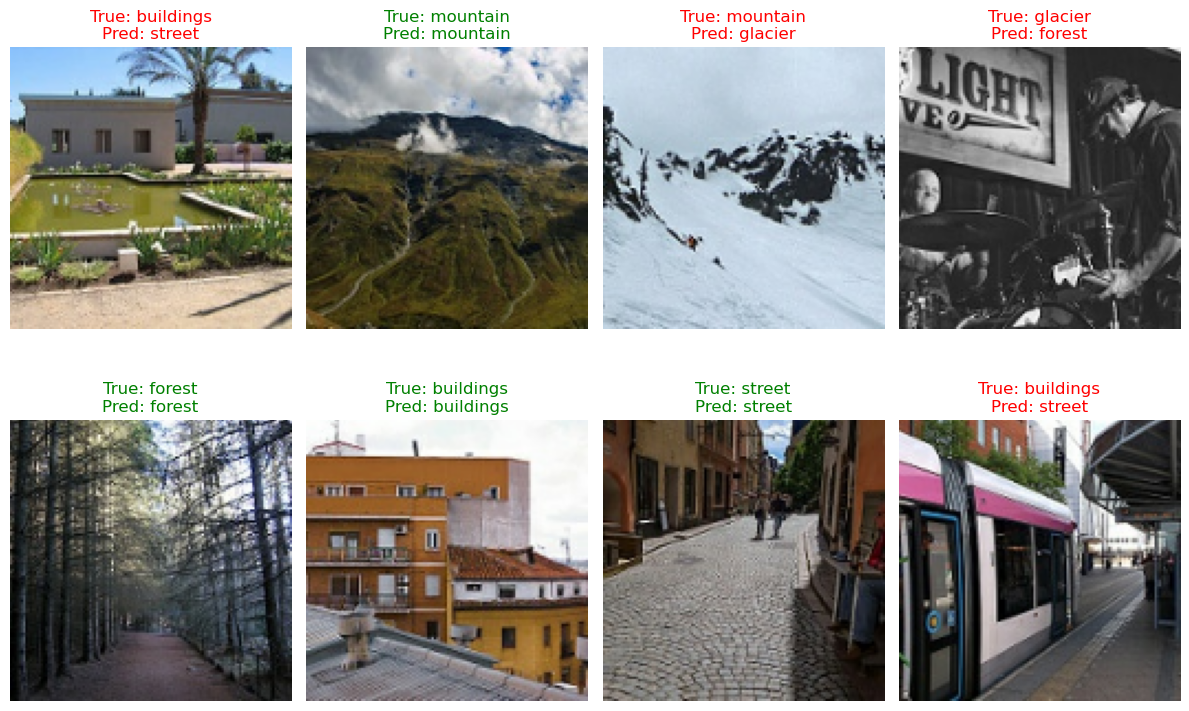

In [290]:
# Pick a few sample batches from val_ds
for images, labels in val_ds.take(1):
    plt.figure(figsize=(12, 8))

    # Generate predictions for the entire batch
    predictions = baseline_model.predict(images)

    # Display 8 randomly selected images from the batch
    for i in range(8):  # show 8 random images
        index = random.randint(0, len(images) - 1)

        # Create subplot for each image (2 rows x 4 columns layout)
        plt.subplot(2, 4, i+1)

        # Show the selected image
        plt.imshow(images[index].numpy().astype("uint8"))

        # Get the true and predicted class labels
        true_label = class_names[np.argmax(labels[index])]
        predicted_label = class_names[np.argmax(predictions[index])]

        # Set the title color based on correctness of prediction
        color = 'green' if true_label == predicted_label else 'red'

        # Display true and predicted labels as title
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis('off')

    # Adjust spacing between subplots and show the figure
    plt.tight_layout()
    plt.show()

## • Discuss key observations about model performance.

Ans:

The baseline model achieved a validation accuracy of approximately 72.7%, indicating decent generalization on unseen data. Through the classification report, it was shown that it predicted categories like forest and street very accurately, while it struggled more with mountain and glacier, probably because these classes seem similar to others like sea and buildings. Furthermore, the confusion matrix showed that some classes were often mixed up. For example: mountains were sometimes predicted as glaciers, and buildings as streets. 

The sample image predictions also confirmed that the baseline model accurately predicted images such as buildings, street, forest and mountain. However, there were also misclassifications since, a building image was misclassified as a street due to the presence of a road and a vehicle, and a glacier image was also predicted as a forest. Overall, while the model performs well in many cases, further enhancements such as a deeper model could help reduce confusion between visually similar classes.

## 3.1.3 Design, Train , and Evaluate Deeper Architecture with Regularization Layer

## 1. Model Architecture

## • Extend the baseline model by modifying the number of filters and layers to build deeper architecture{at least double the layer in comparison to baseline model}.

## • Extend the layers introducing the following regularization techniques.

In [225]:
# Define the deeper Convolutional Neural Network model architecture
final_model_even_deeper = Sequential([

    # Input layer, specifies the expected shape of input images
    Input(shape=(img_height, img_width, 3), name="input_layer"),

    # Rescaling layer, normalizes pixel values from [0, 255] to [0, 1] for better training stability
    Rescaling(1./255, name="rescaling_layer"),

    # Conv Block 1
    Conv2D(64, (3, 3), padding='same', name="conv1_1"),  # 64 filters, 3x3 kernel,
    BatchNormalization(name="bn1_1"),                    # Normalizes activations 
    Activation('relu', name="relu1_1"),                  # ReLU activation function
    MaxPooling2D((2, 2), name="pool1"),     # Downsamples feature maps by taking the max value in 2x2 windows
    Dropout(0.25, name="dropout1"),        # Regularization, randomly sets 25% of input units to 0 during training

    # Conv Block 2
    Conv2D(128, (3, 3), padding='same', name="conv2_1"),   # 128 filters
    BatchNormalization(name="bn2_1"),
    Activation('relu', name="relu2_1"),
    MaxPooling2D((2, 2), name="pool2"),
    Dropout(0.25, name="dropout2"),

    # Conv Block 3
    Conv2D(256, (3, 3), padding='same', name="conv3_1"),    # 256 filters
    BatchNormalization(name="bn3_1"),
    Activation('relu', name="relu3_1"),
    MaxPooling2D((2, 2), name="pool3"),
    Dropout(0.25, name="dropout3"),

    # Conv Block 4
    Conv2D(256, (3, 3), padding='same', name="conv4_1"),    # 256 filters
    BatchNormalization(name="bn4_1"),
    Activation('relu', name="relu4_1"),
    MaxPooling2D((2, 2), name="pool4"),
    Dropout(0.25, name="dropout4"),

    # Flatten layer
    Flatten(name="flatten_layer"),

    # Fully Connected Block 1
    Dense(512, name="fc1"),
    BatchNormalization(name="bn_fc1"),
    Activation('relu', name="relu_fc1"),
    Dropout(0.5, name="dropout_fc1"),

    # Fully Connected Block 2
    Dense(256, name="fc2"),
    BatchNormalization(name="bn_fc2"),
    Activation('relu', name="relu_fc2"),
    Dropout(0.5, name="dropout_fc2"),

    # Fully Connected Block 3
    Dense(128, name="fc3"),
    BatchNormalization(name="bn_fc3"),
    Activation('relu', name="relu_fc3"),
    Dropout(0.5, name="dropout_fc3"),

    # Fully Connected Block 4
    Dense(64, name="fc4"),
    BatchNormalization(name="bn_fc4"),
    Activation('relu', name="relu_fc4"),
    Dropout(0.5, name="dropout_fc4"),

    # Output Layer
    Dense(len(class_names), activation='softmax', name="output_layer")
], name="final_model_even_deeper") 

# Compile the model (Optimizer, Loss, Metrics)
final_model_even_deeper.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

# Print the model summary
print("\n--- Model Summary for Deeper Architecture ---")
final_model_even_deeper.summary()


--- Model Summary for Deeper Architecture ---


Model: "final_model_even_deeper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_layer (Rescaling)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1_1 (BatchNormalization)           │ (None, 128, 128, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1_1 (Activation)                 │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2_1 (BatchNormalization)           │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2_1 (Activation)                 │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3_1 (BatchNormalization)           │ (None, 32, 32, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu3_1 (Activation)                 │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout3 (Dropout)                   │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_1 (Conv2D)                     │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4_1 (BatchNormalization)           │ (None, 16, 16, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu4_1 (Activation)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout4 (Dropout)                   │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,529,542 (36.35 MB)

 Trainable params: 9,526,214 (36.34 MB)

 Non-trainable params: 3,328 (13.00 KB)

## • Print and analyze the new model summary.

Ans:

The 'final_model_even_deeper' significantly expanded upon the baseline. It featured four convolutional blocks (with Conv2D filter counts of 64, 128, 256, and 256 respectively) and four fully connected layers (with 512, 256, 128, and 64 units), leading to a total of 8 main learnable layers before the output layer. While this is not a strict doubling of main learnable layers, the overall operational depth (including crucial regularization layers like Batch Normalization and Dropout now integrated throughout) was substantially increased, effectively making it a much deeper model. The model now comprised approximately 9.53 million total parameters, a substantial increase from the baseline. The majority of these parameters were located in the first dense layer (fc1) due to the large number of flattened features. While this enhanced capacity allowed for learning more complex features from the data, it also necessitated careful training and monitoring, as the deeper architecture and larger parameter count bring an inherently higher risk of overfitting (which the regularization aims to mitigate) and increased computational demands for training.

## 2. Model Training

## • Train the deeper model for an appropriate number of epochs.

In [227]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss') # Added monitor here

# Reduces learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

deeper_model_to_train = final_model_even_deeper 

print("--- Training Deeper Model ---")
start_time_deeper = time.time()    # Start timer for deeper model

# Train the model using the .fit() method
history_deeper = deeper_model_to_train.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25, # Max epochs
    callbacks=[early_stop, checkpoint, reduce_lr]
)
end_time_deeper = time.time()     # End timer for deeper model

# Calculate the total training time
training_time_deeper = end_time_deeper - start_time_deeper

# Print the total training time for the deeper model
print(f"Deeper model training time: {training_time_deeper:.2f} seconds")

--- Training Deeper Model ---
Epoch 1/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 894s 3s/step - accuracy: 0.2915 - loss: 1.8893 - val_accuracy: 0.4132 - val_loss: 1.3987 - learning_rate: 0.0010
Epoch 2/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 884s 3s/step - accuracy: 0.5137 - loss: 1.2383 - val_accuracy: 0.6294 - val_loss: 1.0098 - learning_rate: 0.0010
Epoch 3/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 894s 3s/step - accuracy: 0.5742 - loss: 1.1240 - val_accuracy: 0.6308 - val_loss: 0.9973 - learning_rate: 0.0010
Epoch 4/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 870s 2s/step - accuracy: 0.6244 - loss: 1.0255 - val_accuracy: 0.5747 - val_loss: 1.0555 - learning_rate: 0.0010
Epoch 5/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 862s 2s/step - accuracy: 0.6607 - loss: 0.9665 - val_accuracy: 0.5779 - val_loss: 1.0781 - learning_rate: 0.0010
Epoch 6/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 867s 2s/step - accuracy: 0.6894 - loss: 0.8947 - val_accuracy: 0.6676 - val_loss: 0.9407 - learning_rate: 0.0010
Epoch 7/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 817s 2s/step

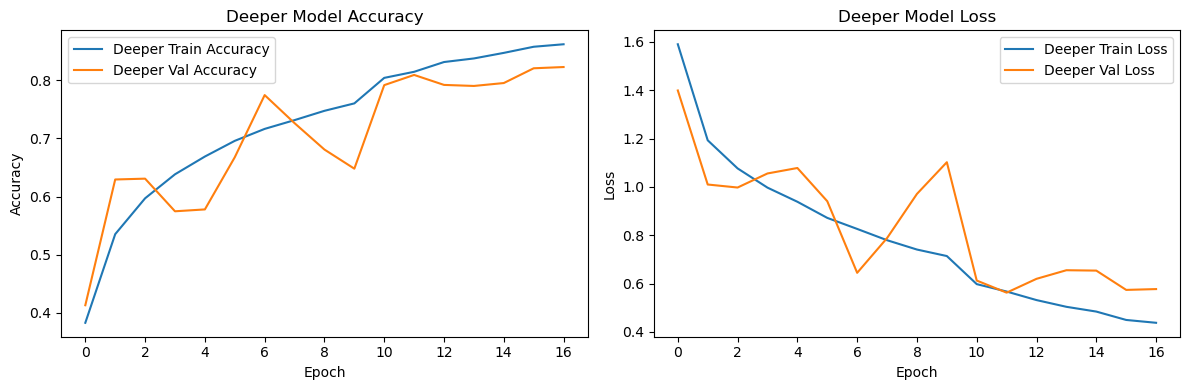

In [229]:
# Plotting for the Deeper Model
plt.figure(figsize=(12, 4))

# Accuracy Plot for Deeper Model
plt.subplot(1, 2, 1)
plt.plot(history_deeper.history['accuracy'], label='Deeper Train Accuracy')
plt.plot(history_deeper.history['val_accuracy'], label='Deeper Val Accuracy')
plt.title("Deeper Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot for Deeper Model
plt.subplot(1, 2, 2)
plt.plot(history_deeper.history['loss'], label='Deeper Train Loss')
plt.plot(history_deeper.history['val_loss'], label='Deeper Val Loss')
plt.title("Deeper Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## • Compare its training time and loss curves against the baseline model.

Ans:

The training time for baseline model was 546.88 seconds (for 5 epochs), while the training time for deeper model was 14527.46 seconds (for 17 epochs). It shows that the deeper model required more time due to additional convolutional layers and regularization components such as Batch Normalization and Dropout.

Additionally, when comparing the loss and accuracy curves of both model, the baseline model showed early signs of overfitting. Its validation loss started to increase after just 2 epochs, and its validation accuracy peaked around 72.5% before declining, even though training accuracy continued to improve. On the other hand, the deeper model benefitted from regularization, and showed better generalization and higher performance. Its validation accuracy reached a significantly higher peak (around 82% by epoch 16-17) and its validation loss achieved a much lower point (around 0.57 by epoch 16-17). Although the deeper model's validation curves appear more 'bumpy' or volatile, especially the validation loss, the overall trend showed it learned more effectively and achieved superior results on the validation set compared to the baseline model.

## 3. Model Evaluation 

## • Evaluate the deeper model on the same performance metrics as the baseline model.

In [252]:
# 1. Get overall loss and accuracy for the Deeper Model
print("\n--- Evaluating Deeper Model (final_model_even_deeper) ---")
print("Calculating overall loss and accuracy for the deeper model...")
deeper_val_loss, deeper_val_acc = final_model_even_deeper.evaluate(val_ds, verbose=0)
print(f"Deeper Model - Validation Loss: {deeper_val_loss:.4f}")   
print(f"Deeper Model - Validation Accuracy: {deeper_val_acc:.4f}") 


--- Evaluating Deeper Model (final_model_even_deeper) ---
Calculating overall loss and accuracy for the deeper model...
Deeper Model - Validation Loss: 0.5626
Deeper Model - Validation Accuracy: 0.8091


Generating predictions for the deeper model on the validation set...

Classification Report (Deeper Model):
              precision    recall  f1-score   support

   buildings       0.80      0.76      0.78       436
      forest       0.86      0.99      0.92       471
     glacier       0.80      0.69      0.74       465
    mountain       0.80      0.75      0.78       493
         sea       0.79      0.85      0.82       453
      street       0.79      0.82      0.80       480

    accuracy                           0.81      2798
   macro avg       0.81      0.81      0.81      2798
weighted avg       0.81      0.81      0.81      2798


Confusion Matrix (Deeper Model):


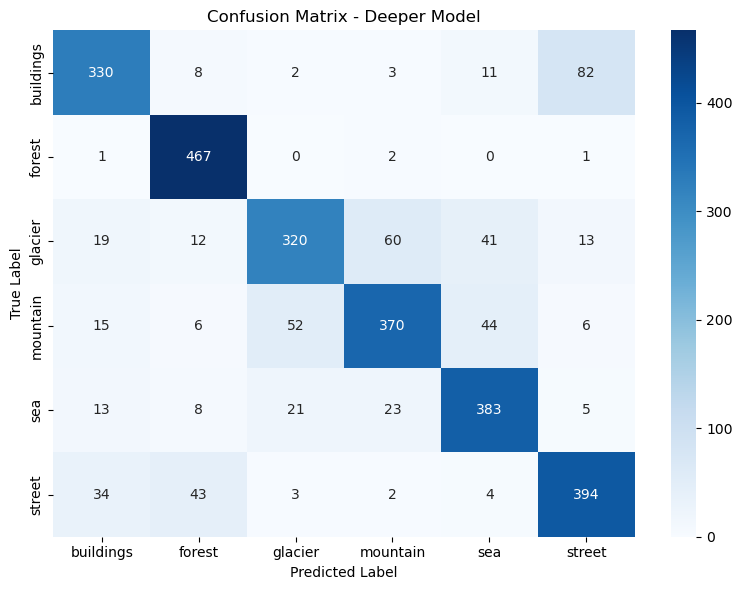

In [254]:
# 2. Generate Predictions, True Labels, Classification Report, and Confusion Matrix for the Deeper Model
y_true_deeper_list = []
y_pred_deeper_list = []

print("Generating predictions for the deeper model on the validation set...")
# Iterate over the validation dataset to get all true labels and predictions
for images, labels in val_ds: 
    true_labels_batch = np.argmax(labels.numpy(), axis=1)
    y_true_deeper_list.extend(true_labels_batch)

    preds_batch = final_model_even_deeper.predict(images, verbose=0)
    pred_labels_batch = np.argmax(preds_batch, axis=1)
    y_pred_deeper_list.extend(pred_labels_batch)

# Convert lists to numpy arrays
y_true_deeper_np = np.array(y_true_deeper_list)
y_pred_deeper_np = np.array(y_pred_deeper_list)

# Print Classification Report for the Deeper Model
print("\nClassification Report (Deeper Model):")
print(classification_report(y_true_deeper_np, y_pred_deeper_np, target_names=class_names, zero_division=0))

# Generate and Plot Confusion Matrix for the Deeper Model
print("\nConfusion Matrix (Deeper Model):")
conf_mat_deeper = confusion_matrix(y_true_deeper_np, y_pred_deeper_np)

plt.figure(figsize=(8, 6)) # Adjusted for a single matrix display
sns.heatmap(conf_mat_deeper, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Deeper Model')
plt.tight_layout()
plt.show()

## • Discuss improvements (or lack thereof) compared to the baseline model.

Ans:

The deeper model showed a significant improvement over the baseline model. Its validation accuracy went from about 72.3% (baseline) to 80.9%, and the validation loss dropped from 0.7963 (baseline) to 0.5626. This general improvement is also shown when the individual classes are analyzed. For example: the F1-score for "buildings" went from 0.67 to 0.78, "glacier" from 0.65 to 0.74, "mountain" from 0.66 to 0.78, and "sea" from 0.67 to 0.82, proving better performance in identifying these scenes. While "forest" and "street" were already quite good in the baseline, the deeper model even slightly improved their F1-scores (forest: 0.91 to 0.92, street: 0.76 to 0.80).


Similarly, while looking at the confusion matrices, the deeper model generally has higher numbers along the main diagonal (correct predictions) and lower numbers off-diagonal (misclassifications) compared to the baseline. For example, the baseline often misclassified "mountain" as "sea" (115 instances), but the deeper model reduced this specific confusion significantly (only 44 instances). Similarly, the baseline confused 95 "buildings" as "street," while the deeper model reduced this to 82. Although some confusions are there, particularly between visually similar classes such as "glacier" and "mountain", the deeper model with regularization has clearly learned to differentiate between the scenes more effectively.

## 3.1.4 Experimentation and Comparative Analysis

## 1. Baseline vs. Deeper Model Performance 

## • Compare classification accuracy, loss, and evaluation metrics.

Ans:

The deeper model reached its validation accuracy to 80.9% from 72.3% baseline validation accuracy and dropped the validation loss to 0.5626 from 0.7963 baseline validation loss, demonstrating a significant improvement over the baseline model. In addition, when analyzing the evaluation metrics from the classification reports of both models, the deeper model outperformed the baseline model. For instance: the metrics from deeper model of the F1-score for "buildings" went from 0.67 to 0.78, "glacier" from 0.65 to 0.74, "mountain" from 0.66 to 0.78, and "sea" from 0.67 to 0.82, proving better performance in identifying these scenes. While "forest" and "street" were already quite good in the baseline, the deeper model even slightly improved their F1-scores (forest: 0.91 to 0.92, street: 0.76 to 0.80). Although the deeper model's validation curves appeared more 'bumpy' or volatile, especially the validation loss, the overall trend showed it learned more effectively and achieved superior results on the validation set compared to the baseline model.

## • Discuss whether adding more layers and filters improved performance.

Ans:

Yes, adding more layers and filters, combined with regularization techniques such as Batch Normalization and Dropout, improved the performance of model. The deeper model achieved a significantly higher validation accuracy of about 80.9% compared to the baseline model (72.3%), and lower validation loss of 0.5626 compared to baseline's 0.7963. This demonstrates that the increased capacity from more layers and more filters was beneficial. The regularization significantly helped prevent this deeper model from simply memorizing the training data (overfitting) and allowed it to generalize better to new, or unseen images. This improvement was shown across most categories with classes including buildings, glacier, mountain, and sea, showing visible gains in their F1 scores. This referred that the deeper model became better at accurately identifying the images and reducing misclassifications.

## 2. Computational Efficiency

## • Compare training time and computational cost of the two models.

Ans:

There is a huge difference in computational efficiency when we looked at how much effort or time it took to train these models. The baseline model was fast and completed its training in just about 547 seconds, while the deeper model needed much more time around 14,527 seconds to complete its training. This wasn't just because the deeper model trained for more epochs, but each individual training epoch also took considerably longer time for deeper model. Therefore, the higher computational cost of the deeper model makes sense since it has more layers such as the additional convolutional and dense layers, additional filters within those layers, and additional operations such as Batch Normalization and Dropout. All these operations refer that the computer has to do a lot more calculateions for every image which it processes, both when learning and adjusting its internal weights. Hence, while the deeper model performed better than the baseline model, it also came at the cost of needing more computing power and taking significantly more time to train.

## • Discuss the trade - offs between model complexity and efficiency.

Ans:

In this task, we observed a common trade-off in deep learning, achieving better performance often requires accepting lower efficiency. The deeper model with more layers, filters, and regularization techniques was more accurate at classifying scene images. However, it came at the cost of increased training time and higher computational requirements. On the other hand, the simpler baseline model trained faster and was more resource-efficient, but its accuracy was lower as compared with the deeper model. 

This is quite similar to comparing a high-performing sports car and an economical everyday vehicle. The deeper model (like the sports car) provides better results (higher accuracy) but requires more fuel (computing power and time). On the other hand, the baseline model (like the economical car) is faster and cheaper to run, but won't perform as well in complex tasks. Therefore, in real-world scenario, it is significant to find the right balance depending on the task or project objectives, whether that means achieving the highest possible accuracy or optimizing for faster, more resource-efficient performance. 

## 3. Optimizer Analysis: SGD vs Adam

## • Train the deeper model with SGD and then Adam.

In [300]:
# Define a function to build the deeper model with SGD and Adam
def build_deeper_model(input_shape, num_classes):
    model = Sequential([

        # Input and preprocessing layer
        Input(shape=input_shape, name="input_layer"),
        
        # Normalize pixel values to [0, 1]
        Rescaling(1./255, name="rescaling_layer"),

        # Conv Block 1
        Conv2D(64, (3, 3), padding='same', name="conv1_1"),    # First conv layer
        BatchNormalization(name="bn1_1"),                      # Normalize activations
        Activation('relu', name="relu1_1"),                    # ReLU activation
        MaxPooling2D((2, 2), name="pool1"),                    # Downsample feature map
        Dropout(0.25, name="dropout1"),                        # Prevent overfitting

        # Conv Block 2
        Conv2D(128, (3, 3), padding='same', name="conv2_1"),
        BatchNormalization(name="bn2_1"),
        Activation('relu', name="relu2_1"),
        MaxPooling2D((2, 2), name="pool2"),
        Dropout(0.25, name="dropout2"),

        # Conv Block 3
        Conv2D(256, (3, 3), padding='same', name="conv3_1"),
        BatchNormalization(name="bn3_1"),
        Activation('relu', name="relu3_1"),
        MaxPooling2D((2, 2), name="pool3"),
        Dropout(0.25, name="dropout3"),

        # Conv Block 4
        Conv2D(256, (3, 3), padding='same', name="conv4_1"),
        BatchNormalization(name="bn4_1"),
        Activation('relu', name="relu4_1"),
        MaxPooling2D((2, 2), name="pool4"),
        Dropout(0.25, name="dropout4"),

        # Flatten the output for the dense layers
        Flatten(name="flatten_layer"),

        # Fully Connected Layer 1
        Dense(512, name="fc1"),
        BatchNormalization(name="bn_fc1"),
        Activation('relu', name="relu_fc1"),
        Dropout(0.5, name="dropout_fc1"),

        # Fully Connected Layer 2
        Dense(256, name="fc2"),
        BatchNormalization(name="bn_fc2"),
        Activation('relu', name="relu_fc2"),
        Dropout(0.5, name="dropout_fc2"),

        # Fully Connected Layer 3
        Dense(128, name="fc3"),
        BatchNormalization(name="bn_fc3"),
        Activation('relu', name="relu_fc3"),
        Dropout(0.5, name="dropout_fc3"),

        # Fully Connected Layer 4
        Dense(64, name="fc4"),
        BatchNormalization(name="bn_fc4"),
        Activation('relu', name="relu_fc4"),
        Dropout(0.5, name="dropout_fc4"),

        # Output layer with softmax activation for multi-class classification
        Dense(num_classes, activation='softmax', name="output_layer")
    ], name="final_model_even_deeper_instance")
    return model

# Define input shape and number of output classes
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)
epochs_for_optimizers = 25   # Number of training epochs

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

# Train with SGD Optimizer 
print("\n--- Training Deeper Model with SGD Optimizer ---")
model_sgd = build_deeper_model(input_shape, num_classes)

# Define the SGD optimizer with a typical learning rate and momentum
optimizer_sgd = SGD(learning_rate=0.01, momentum=0.9) 

# Compile the model
model_sgd.compile(optimizer=optimizer_sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print model architecture summary
print("Model Summary (SGD):")
model_sgd.summary()

# Start training and record time
start_time_sgd = time.time()
history_sgd = model_sgd.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_for_optimizers,
    callbacks=[
        early_stop,
        ModelCheckpoint('best_model_sgd.keras', save_best_only=True, monitor='val_loss'), 
        reduce_lr
    ]
)
end_time_sgd = time.time()
training_time_sgd = end_time_sgd - start_time_sgd

# Print training time and epoch count
print(f"Deeper model (SGD) training time: {training_time_sgd:.2f} seconds, "
      f"trained for {len(history_sgd.history['loss'])} epochs.")

# Train with Adam Optimizer 
print("\n--- Training Deeper Model with Adam Optimizer ---")
model_adam = build_deeper_model(input_shape, num_classes)

# Define the Adam optimizer with default learning rate
optimizer_adam = Adam(learning_rate=0.001) 

# Compile the model
model_adam.compile(optimizer=optimizer_adam,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Print model architecture summary
print("Model Summary (Adam):")
model_adam.summary()

# Start training and record time
start_time_adam = time.time()
history_adam = model_adam.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_for_optimizers,
    callbacks=[
        early_stop,
        ModelCheckpoint('best_model_adam.keras', save_best_only=True, monitor='val_loss'), 
        reduce_lr
    ]
)
end_time_adam = time.time()
training_time_adam = end_time_adam - start_time_adam

# Print training time and epoch count
print(f"Deeper model (Adam) training time: {training_time_adam:.2f} seconds, "
      f"trained for {len(history_adam.history['loss'])} epochs.")

print("\nTraining with both optimizers complete.")


--- Training Deeper Model with SGD Optimizer ---
Model Summary (SGD):


Model: "final_model_even_deeper_instance"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_layer (Rescaling)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1_1 (BatchNormalization)           │ (None, 128, 128, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1_1 (Activation)                 │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2_1 (BatchNormalization)           │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2_1 (Activation)                 │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3_1 (BatchNormalization)           │ (None, 32, 32, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu3_1 (Activation)                 │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout3 (Dropout)                   │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_1 (Conv2D)                     │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4_1 (BatchNormalization)           │ (None, 16, 16, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu4_1 (Activation)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout4 (Dropout)                   │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,529,542 (36.35 MB)

 Trainable params: 9,526,214 (36.34 MB)

 Non-trainable params: 3,328 (13.00 KB)

Epoch 1/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 995s 3s/step - accuracy: 0.3010 - loss: 1.8114 - val_accuracy: 0.5089 - val_loss: 1.2542 - learning_rate: 0.0100
Epoch 2/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 982s 3s/step - accuracy: 0.4935 - loss: 1.2408 - val_accuracy: 0.5625 - val_loss: 1.0632 - learning_rate: 0.0100
Epoch 3/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 973s 3s/step - accuracy: 0.5516 - loss: 1.1597 - val_accuracy: 0.6058 - val_loss: 0.9537 - learning_rate: 0.0100
Epoch 4/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 1018s 3s/step - accuracy: 0.5694 - loss: 1.0964 - val_accuracy: 0.5018 - val_loss: 1.1886 - learning_rate: 0.0100
Epoch 5/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 967s 3s/step - accuracy: 0.5941 - loss: 1.0611 - val_accuracy: 0.6265 - val_loss: 0.9338 - learning_rate: 0.0100
Epoch 6/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 1145s 3s/step - accuracy: 0.6138 - loss: 1.0194 - val_accuracy: 0.5064 - val_loss: 1.2793 - learning_rate: 0.0100
Epoch 7/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 1246s 4s/step - accuracy: 0.6369 - loss:

Model: "final_model_even_deeper_instance"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_layer (Rescaling)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1_1 (BatchNormalization)           │ (None, 128, 128, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1_1 (Activation)                 │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2_1 (BatchNormalization)           │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2_1 (Activation)                 │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3_1 (BatchNormalization)           │ (None, 32, 32, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu3_1 (Activation)                 │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout3 (Dropout)                   │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_1 (Conv2D)                     │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4_1 (BatchNormalization)           │ (None, 16, 16, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu4_1 (Activation)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout4 (Dropout)                   │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,529,542 (36.35 MB)

 Trainable params: 9,526,214 (36.34 MB)

 Non-trainable params: 3,328 (13.00 KB)

Epoch 1/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.2897 - loss: 1.8835 - val_accuracy: 0.4503 - val_loss: 1.3140 - learning_rate: 0.0010
Epoch 2/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 808s 2s/step - accuracy: 0.5094 - loss: 1.2779 - val_accuracy: 0.6179 - val_loss: 1.0422 - learning_rate: 0.0010
Epoch 3/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 816s 2s/step - accuracy: 0.5717 - loss: 1.1354 - val_accuracy: 0.6544 - val_loss: 0.8939 - learning_rate: 0.0010
Epoch 4/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 806s 2s/step - accuracy: 0.6135 - loss: 1.0258 - val_accuracy: 0.5082 - val_loss: 1.2299 - learning_rate: 0.0010
Epoch 5/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.6567 - loss: 0.9621 - val_accuracy: 0.5958 - val_loss: 1.0571 - learning_rate: 0.0010
Epoch 6/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 816s 2s/step - accuracy: 0.6885 - loss: 0.8994 - val_accuracy: 0.7112 - val_loss: 0.7597 - learning_rate: 0.0010
Epoch 7/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 815s 2s/step - accuracy: 0.7078 - loss: 0.


--- Evaluating Deeper Model (SGD Optimizer) ---
SGD Model - Final Validation Loss: 0.8193
SGD Model - Final Validation Accuracy: 0.7112

Classification Report (SGD Model):
              precision    recall  f1-score   support

   buildings       0.89      0.56      0.69       436
      forest       0.73      0.99      0.84       471
     glacier       0.65      0.69      0.67       465
    mountain       0.84      0.51      0.63       493
         sea       0.56      0.81      0.66       453
      street       0.78      0.70      0.74       480

    accuracy                           0.71      2798
   macro avg       0.74      0.71      0.71      2798
weighted avg       0.74      0.71      0.71      2798



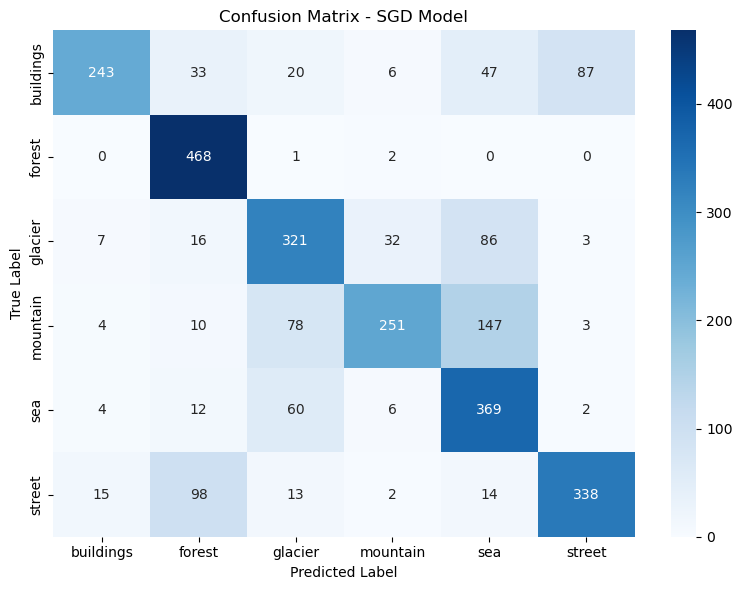

In [309]:
# Evaluate SGD Model 
print("\n--- Evaluating Deeper Model (SGD Optimizer) ---")

# Evaluate the model on the validation dataset
val_loss_sgd, val_acc_sgd = model_sgd.evaluate(val_ds, verbose=0)
print(f"SGD Model - Final Validation Loss: {val_loss_sgd:.4f}")
print(f"SGD Model - Final Validation Accuracy: {val_acc_sgd:.4f}")

# Generate predictions for classification report and confusion matrix
y_true_sgd_list = []   # To store true class labels
y_pred_sgd_list = []   # To store predicted class labels

# Loop through the validation dataset
for images, labels in val_ds:

    # Convert one-hot encoded labels to class indices
    y_true_sgd_list.extend(np.argmax(labels.numpy(), axis=1))

    # Predict class probabilities using the trained model
    preds = model_sgd.predict(images, verbose=0)

    # Get predicted class indices from probabilities
    y_pred_sgd_list.extend(np.argmax(preds, axis=1))

# Print classification metrics such as precision, recall, F1-score
print("\nClassification Report (SGD Model):")
print(classification_report(y_true_sgd_list, y_pred_sgd_list, target_names=class_names, zero_division=0))

# Generate and display a confusion matrix
conf_mat_sgd = confusion_matrix(y_true_sgd_list, y_pred_sgd_list)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_sgd, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - SGD Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


--- Evaluating Deeper Model (Adam Optimizer) ---
Adam Model - Final Validation Loss: 0.5572
Adam Model - Final Validation Accuracy: 0.8281

Classification Report (Adam Model):
              precision    recall  f1-score   support

   buildings       0.78      0.78      0.78       436
      forest       0.92      0.99      0.95       471
     glacier       0.84      0.69      0.76       465
    mountain       0.86      0.75      0.80       493
         sea       0.78      0.90      0.84       453
      street       0.80      0.85      0.82       480

    accuracy                           0.83      2798
   macro avg       0.83      0.83      0.83      2798
weighted avg       0.83      0.83      0.83      2798



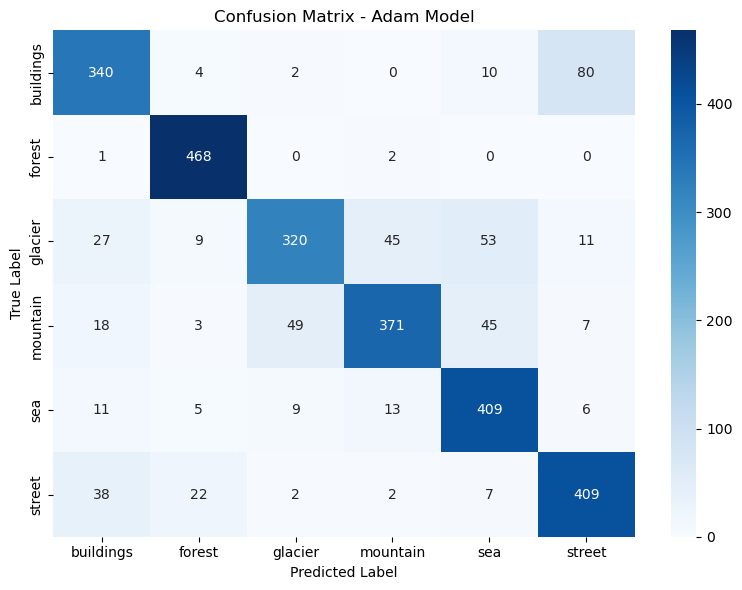

In [302]:
# Evaluate Adam Model 
print("\n--- Evaluating Deeper Model (Adam Optimizer) ---")

# Evaluate the model's loss and accuracy on the validation dataset
val_loss_adam, val_acc_adam = model_adam.evaluate(val_ds, verbose=0)
print(f"Adam Model - Final Validation Loss: {val_loss_adam:.4f}")
print(f"Adam Model - Final Validation Accuracy: {val_acc_adam:.4f}")

# Generate predictions for classification report and confusion matrix
y_true_adam_list = []
y_pred_adam_list = []
for images, labels in val_ds:
    y_true_adam_list.extend(np.argmax(labels.numpy(), axis=1))
    preds = model_adam.predict(images, verbose=0)
    y_pred_adam_list.extend(np.argmax(preds, axis=1))

print("\nClassification Report (Adam Model):")
print(classification_report(y_true_adam_list, y_pred_adam_list, target_names=class_names, zero_division=0))

# Compute the confusion matrix
conf_mat_adam = confusion_matrix(y_true_adam_list, y_pred_adam_list)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_adam, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Adam Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## • Compare the impact of these optimizers on convergence speed and final performance.

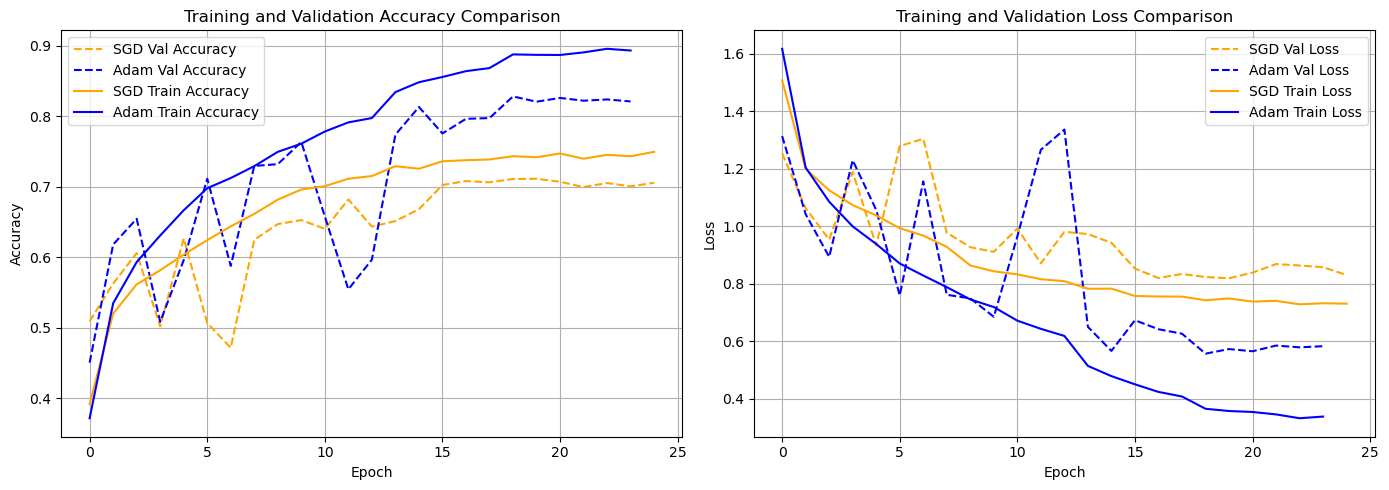

In [304]:
# Plotting Learning Curves for Comparison 
plt.figure(figsize=(14, 5))

# Plotting Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_sgd.history['val_accuracy'], label='SGD Val Accuracy', color='orange', linestyle='--')
plt.plot(history_adam.history['val_accuracy'], label='Adam Val Accuracy', color='blue', linestyle='--')
plt.plot(history_sgd.history['accuracy'], label='SGD Train Accuracy', color='orange')
plt.plot(history_adam.history['accuracy'], label='Adam Train Accuracy', color='blue')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_sgd.history['val_loss'], label='SGD Val Loss', color='orange', linestyle='--')
plt.plot(history_adam.history['val_loss'], label='Adam Val Loss', color='blue', linestyle='--')
plt.plot(history_sgd.history['loss'], label='SGD Train Loss', color='orange')
plt.plot(history_adam.history['loss'], label='Adam Train Loss', color='blue')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [311]:
# Print comparison summary of SGD and Adam model
print("\n--- Comparison Summary ---")
print(f"SGD Model: Trained for {len(history_sgd.history['loss'])} epochs in {training_time_sgd:.2f}s. Final Val Acc: {val_acc_sgd:.4f}, Final Val Loss: {val_loss_sgd:.4f}")
print(f"Adam Model: Trained for {len(history_adam.history['loss'])} epochs in {training_time_adam:.2f}s. Final Val Acc: {val_acc_adam:.4f}, Final Val Loss: {val_loss_adam:.4f}")


--- Comparison Summary ---
SGD Model: Trained for 25 epochs in 23063.45s. Final Val Acc: 0.7112, Final Val Loss: 0.8193
Adam Model: Trained for 24 epochs in 21598.05s. Final Val Acc: 0.8281, Final Val Loss: 0.5572


When comparing the Adam and SGD optimizers on the deeper model, Adam demonstrated superior performance in both convergence speed and final results. The Adam optimizer achieved a significantly higher final validation accuracy of 82.81% and lower validation loss of 0.5572, while the SGD optimizer achieved the final validation accuracy of 71.12% and validation loss of 0.8193, comparatively low performance as compared with the Adam optimizer. In addition, the classification report and confusion matrix for the Adam optimizer showed better precision, recall, and F1 scores across most classes when compared to the SGD optimizer. Moreover, SGD model took quite longer time 23063.45 seconds, when compared with the Adam optimizer (21598.05s).

## 4. Challenges and Observation

## • Discuss any difficulties faced, such as overfitting and underfitting.

Ans:

One of the difficulties faced was dealing with overfitting. While training our initial baseline model, we noticed that it was doing well on training data, however, it was not doing so well on validation data. This means it was memorizing the training images rather than learning how to generalize to new ones. To address this, we added operations such as Dropout and Batch Normalization in the deeper model, and also used tools such as EarlyStopping and ReduceLROnPlateau. These updates helped in making the model more reliable and prevented it from overfitting as much. Other challenge or difficulty faces was the longer training time and higher computational cost of the deeper model since it took more time and resources for training when compared with the baseline model. We also tried using different optimizers such as Adam and SGD, where Adam model outperformed the SGD model in terms of validation accuracy, validation loss, and classification report.

## • Report the total training time for deeper architecture.

Ans: 

The deeper model architecture, which had more layers including four convolutional blocks, four fully connected layers, and regularization techniques such as Batch Normalization and Dropout, took a lot of time to train. When we train it using the Adam optimizer and added tools such as EarlyStopping and ReduceLROnPlateau, the total training time was about 14,527 seconds (around 4 hours). The training stopped after 17 epochs due to Early Stopping (as it noticed that the model might start overfitting, so it stopped and kept the best version of the model). This long training time showed how much more computational power is required for a complex model like this deeper model when compared with the simpler one. Additionally, while training the deeper architecture using different optimizers, it took 23063.45 seconds for SGD and 21598.05 seconds for Adam to complete the training.

## • Mention if hardware acceleration (e.g. Google Colab, with GPU/TPU was used.

Ans:

All models training and evaluation are conducted using a Jupyter notebook environment with CPU-only computation.

## 3.2 Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning).

## 3.2.1 Loading and Adapting a Pre - Trained Model

In [348]:
# Load training data from folders and split it into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_folder,               
    label_mode='categorical',
    image_size=(299, 299),      # (3.2.2)resize images to 299x299 (InceptionV3 input size)
    batch_size=32,              # number of images per batch
    validation_split=0.2,       # use 20% of data for validation
    subset='training',          # this is the training data
    seed=42                     # set seed for reproducibility
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    label_mode='categorical',
    image_size=(299, 299),
    batch_size=32,
    validation_split=0.2,       
    subset='validation',        # this is the validation data
    seed=42
)

# Get the class names (labels) from the dataset and count the number of classes
class_names = train_ds.class_names
n_classes = len(class_names)

# Preprocessing layer to normalize image pixels (from 0–255 to 0–1)
rescale = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

# Data augmentation to improve generalization (random flip, rotation, zoom)
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),      # randomly flip images horizontally
    layers.RandomRotation(0.1),           # randomly rotate images
    layers.RandomZoom(0.2)                # randomly zoom into images
])

# Apply normalization and augmentation to training data
train_ds = train_ds.map(lambda x, y: (rescale(x), y))      # normalize pixels
train_ds = train_ds.map(lambda x, y: (augmentation(x), y)) # apply augmentation
val_ds = val_ds.map(lambda x, y: (rescale(x), y))           # only rescaling validation data

Found 13992 files belonging to 6 classes.
Using 11194 files for training.
Found 13992 files belonging to 6 classes.
Using 2798 files for validation.


## 3.2.2 Model Training and Fine - Tuning

In [349]:
# Load the pre-trained InceptionV3 model (excluding the top layers)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # freeze the base model to prevent training its weights initially

# Build the full model by adding custom layers on top of the base model
inputs = tf.keras.Input(shape=(299, 299, 3))       # input layer
x = base_model(inputs, training=False)             # pass input through base model
x = layers.GlobalAveragePooling2D()(x)             # reduce dimensions
x = layers.Dense(128, activation='relu')(x)        # fully connected layer
outputs = layers.Dense(n_classes, activation='softmax')(x)  # output layer with softmax for classification
model = Model(inputs, outputs)

# Compile model for the first training phase (feature extraction)
model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',  # use sparse version for integer labels
              metrics=['accuracy'])

model.summary()

# Train the model with frozen base layers
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Unfreeze the last few layers of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:   # keep earlier layers frozen, unfreeze last 20 layers
    layer.trainable = False

# Re-compile the model to apply changes
model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training (fine-tuning) the unfrozen layers
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=5)

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)          │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,830 (84.17 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1130s 3s/step - accuracy: 0.7226 - loss: 0.8357 - val_accuracy: 0.8903 - val_loss: 0.2929
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1055s 3s/step - accuracy: 0.8825 - loss: 0.3259 - val_accuracy: 0.8989 - val_loss: 0.2628
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1035s 3s/step - accuracy: 0.8912 - loss: 0.2940 - val_accuracy: 0.9039 - val_loss: 0.2478
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1050s 3s/step - accuracy: 0.9035 - loss: 0.2809 - val_accuracy: 0.9124 - val_loss: 0.2372
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1060s 3s/step - accuracy: 0.9019 - loss: 0.2678 - val_accuracy: 0.9107 - val_loss: 0.2307
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1169s 3s/step - accuracy: 0.9066 - loss: 0.2498 - val_accuracy: 0.9117 - val_loss: 0.2331
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1132s 3s/step - accuracy: 0.9104 - loss: 0.2456 - val_accuracy: 0.9135 - val_loss: 0.2299
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1139s 3s/step - accuracy: 0.9084 - loss: 0.2450 - 

## 3.2.3 Model Evaluation and Prediction

In [351]:
# Evaluate the final fine-tuned model on the validation set
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy:.2f}, Loss: {loss:.2f}")

# Generate predictions for classification report
print("\nGenerating predictions for Classification Report...")
y_true_one_hot = []
y_pred_probs = []
for images, labels in val_ds: # Iterate through the validation dataset
    y_true_one_hot.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images, verbose=0))

y_true_classes = np.argmax(y_true_one_hot, axis=1) # Convert one-hot true labels to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)   # Convert probabilities to class indices

print("\n--- Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, zero_division=0))

88/88 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9271 - loss: 0.2043
Validation Accuracy: 0.92, Loss: 0.21

Generating predictions for Classification Report...

--- Classification Report ---
              precision    recall  f1-score   support

   buildings       0.96      0.92      0.94       429
      forest       0.98      0.99      0.99       435
     glacier       0.85      0.86      0.86       475
    mountain       0.89      0.84      0.86       512
         sea       0.94      0.99      0.96       474
      street       0.93      0.96      0.95       473

    accuracy                           0.92      2798
   macro avg       0.92      0.93      0.92      2798
weighted avg       0.92      0.92      0.92      2798



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


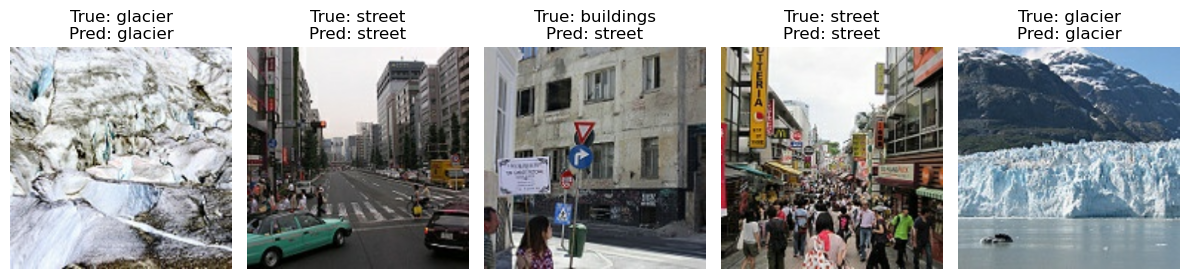

In [352]:
# Visualize predictions on a few validation images
plt.figure(figsize=(12, 6))
for images, labels in val_ds.take(1):      # take one batch from validation set
    preds = model.predict(images)          # get model predictions
    for i in range(min(5, len(images))):   # show up to 5 images
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy())      # display image
        # Corrected line:
        true_label_index = tf.argmax(labels[i]).numpy() # Get scalar index from one-hot true label
        pred_label_index = tf.argmax(preds[i]).numpy()   # Get scalar index from prediction probabilities
        plt.title(f"True: {class_names[true_label_index]}\nPred: {class_names[pred_label_index]}")
        plt.axis('off')
plt.tight_layout()
plt.show()


--- Plotting Combined Training History ---


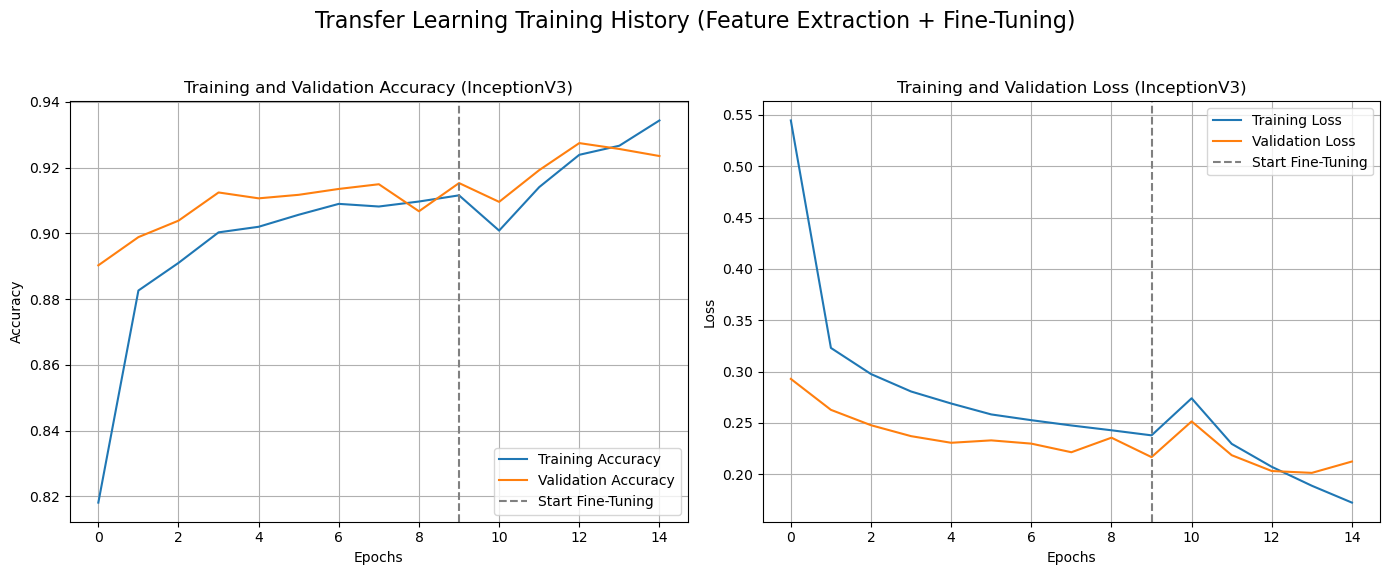

In [361]:
# Plotting Combined Training History
print("\n--- Plotting Combined Training History ---")

# Combine the history objects from the feature extraction and fine-tuning phases
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(len(acc))
initial_epochs = len(history.history['accuracy']) # Number of epochs in feature extraction

plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(initial_epochs - 1, linestyle='--', color='gray', label='Start Fine-Tuning') # Line indicating fine-tuning start
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (InceptionV3)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(initial_epochs - 1, linestyle='--', color='gray', label='Start Fine-Tuning') # Line indicating fine-tuning start
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (InceptionV3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.suptitle("Transfer Learning Training History (Feature Extraction + Fine-Tuning)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

## • Evaluate the fine tuned model using the same performance metrics as in Part A.

Ans:

The final fine-tuned InceptionV3 model was evaluated on the validation and unseen test dataset to assess its real-world generalization capability, using the same metrics as the models in Part A. The model achieved an excellent overall validation accuracy of 92.00% with a correspondingly low validation loss of 0.21, indicating that it makes accurate and confident predictions on new data. Moreover, it worked well across all six types of scenes, with high F1-scores, especially for ‘forest’ (0.99) and ‘sea’ (0.96). Some mix-ups happened between similar scenes like ‘buildings’ and ‘street’, but these were few. Overall, the model showed strong and reliable performance.


--- Evaluating on the Test Set ---
Found 3000 files belonging to 6 classes.
Found 3000 files belonging to 6 classes in the test set.
Evaluating model on test data...
94/94 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9082 - loss: 0.2631
Test Loss: 0.2207
Test Accuracy: 0.9200

Generating predictions for test set classification report...

--- Test Set Classification Report ---
              precision    recall  f1-score   support

   buildings       0.96      0.88      0.92       437
      forest       0.99      0.99      0.99       474
     glacier       0.85      0.89      0.87       553
    mountain       0.90      0.82      0.86       525
         sea       0.94      0.99      0.96       510
      street       0.90      0.97      0.94       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000


--- Test Set Confusion Matrix ---


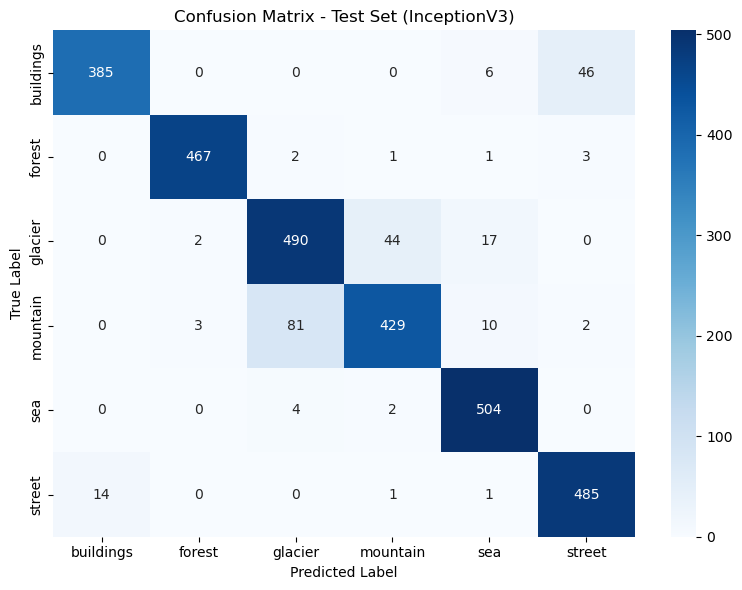

In [369]:
# Evaluating on the Test Set
print("\n--- Evaluating on the Test Set ---")

# Load the test dataset
try:
    # Create the initial dataset object
    test_ds_raw = tf.keras.utils.image_dataset_from_directory(
        test_folder,
        labels='inferred',           # Infer labels from directory structure
        label_mode='categorical',    # Use categorical labels
        image_size=(299, 299),       # Resize images to match the model's 
        batch_size=32,               # Process images in batches
        shuffle=False                
    )

    # Extract file paths and class names immediately after loading, before transformations
    num_test_files = len(test_ds_raw.file_paths)
    test_class_names = test_ds_raw.class_names
    print(f"Found {num_test_files} files belonging to {len(test_class_names)} classes in the test set.")

    # Check if test class names match training class names
    if 'class_names' in globals() and test_class_names != class_names:
         print("Warning: Test set class names do not match training set class names!")
         print(f"Train classes: {class_names}")
         print(f"Test classes: {test_class_names}")
    elif 'class_names' not in globals():
         print("Warning: Training class_names variable not found for comparison.")
         class_names = test_class_names # Use test names if train names unavailable

    # Applying the same rescaling (normalization) as used for training/validation data
    rescale_test = tf.keras.Sequential([layers.Rescaling(1./255)])
    test_ds = test_ds_raw.map(lambda x, y: (rescale_test(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE) # Optimize performance

    # Evaluate the fine-tuned model on the unseen test dataset
    print("Evaluating model on test data...")
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Generate predictions for the test set
    print("\nGenerating predictions for test set classification report...")
    y_true_test_list = []
    y_pred_test_probs = []

    for images, labels in test_ds: # Iterate using the transformed dataset
        y_true_test_list.extend(labels.numpy())
        preds = model.predict(images, verbose=0)
        y_pred_test_probs.extend(preds)

    y_true_test_classes = np.argmax(y_true_test_list, axis=1)
    y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

    # Print Classification Report for the test set
    print("\n--- Test Set Classification Report ---")
    print(classification_report(y_true_test_classes, y_pred_test_classes, target_names=test_class_names, zero_division=0))

    # Generate and Plot Confusion Matrix for the test set
    print("\n--- Test Set Confusion Matrix ---")
    conf_mat_test = confusion_matrix(y_true_test_classes, y_pred_test_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_class_names, yticklabels=test_class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Test Set (InceptionV3)')
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: Test directory not found at {test_folder}")
except Exception as e:
    print(f"An error occurred during test set evaluation: {e}")


--- Visualizing Sample Predictions on Test Set ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


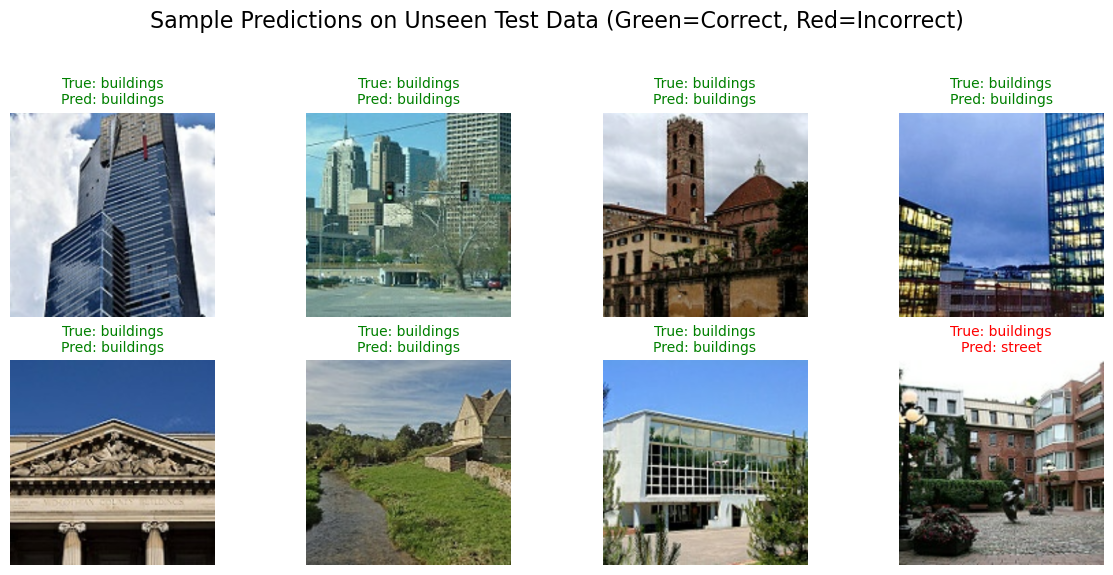

In [384]:
# Visualize predictions on test data samples without shuffling the test data
print("\n--- Visualizing Sample Predictions on Test Set ---")

plt.figure(figsize=(12, 6)) 

# Take one batch from the test dataset
for images, labels in test_ds.take(1):
    # Make predictions on this batch
    predictions = model.predict(images)

    # Display the first 8 images 
    num_images_to_show = min(8, len(images)) 

    for i in range(num_images_to_show):
        plt.subplot(2, 4, i + 1) # Create a 2x4 grid of subplots

        # Display the image
        plt.imshow(images[i].numpy())
        plt.axis('off')

        # Get the true label index 
        true_label_index = np.argmax(labels[i].numpy())
        true_label_name = test_class_names[true_label_index]

        # Get the predicted label index 
        predicted_label_index = np.argmax(predictions[i])
        predicted_label_name = test_class_names[predicted_label_index]

        # Set title color based on correctness
        title_color = 'green' if true_label_index == predicted_label_index else 'red'

        # Set the title for the subplot
        plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", color=title_color, fontsize=10)

plt.suptitle("Sample Predictions on Unseen Test Data (Green=Correct, Red=Incorrect)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


--- Visualizing Sample Predictions on Test Set ---
Found 3000 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


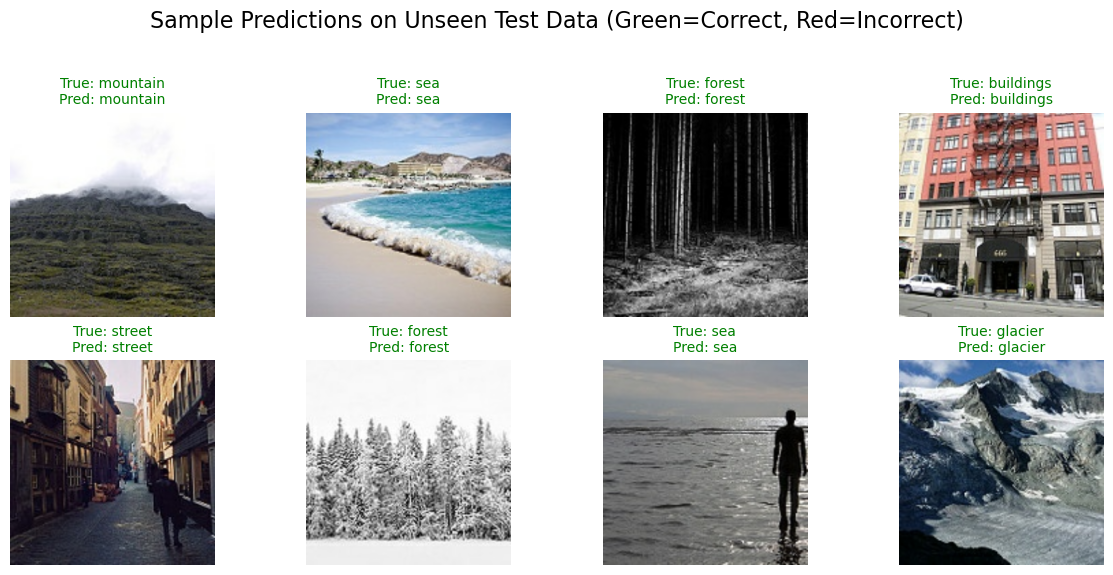

In [388]:
# Visualizing Sample Predictions on Test Set by shuflling it
print("\n--- Visualizing Sample Predictions on Test Set ---")

# Create a SHUFFLED version of the test dataset for visualization
test_ds_shuffled_for_viz = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(299, 299), 
    batch_size=32,         
    shuffle=True,          # shuffle it for visualization              
)

# Apply the same rescaling
rescale_viz = tf.keras.Sequential([layers.Rescaling(1./255)])
test_ds_shuffled_for_viz = test_ds_shuffled_for_viz.map(
    lambda x, y: (rescale_viz(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(buffer_size=tf.data.AUTOTUNE)


plt.figure(figsize=(12, 6))

# Take one batch from the SHUFFLED test dataset
for images, labels in test_ds_shuffled_for_viz.take(1): # Use the shuffled dataset
    predictions = model.predict(images)
    num_images_to_show = min(8, len(images))

    for i in range(num_images_to_show):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

        true_label_index = np.argmax(labels[i].numpy())
        true_label_name = test_class_names[true_label_index] 

        predicted_label_index = np.argmax(predictions[i])
        predicted_label_name = test_class_names[predicted_label_index]

        title_color = 'green' if true_label_index == predicted_label_index else 'red'
        plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", color=title_color, fontsize=10)

plt.suptitle("Sample Predictions on Unseen Test Data (Green=Correct, Red=Incorrect)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## • Make predictions on test data and compare results with the baseline and deeper models from Part A.

Ans:

When we compared the fine-tuned InceptionV3 model with the models built from scratch, it clearly performed better. It got a much higher accuracy (92%) on the test data, while the scratch models only reached about 72% and 83%. This means InceptionV3 was much better at recognizing new images. It also made fewer mistakes between similar-looking scenes like 'buildings' and 'street'. Overall, using a pre-trained model like InceptionV3 helped it learn more effectively and give more accurate results than training from scratch.

## • Discuss whether transfer learning outperforms training from scratch for your dataset.

Ans:

For our scene classification dataset, the transfer learning with the pre-trained InceptionV3 model significantly outperformed the models trained from scratch. The pre-trained InceptionV3 model achieved an impressive 92% accuracy on the unseen test data, which is higher than the 72% accuracy achieved by the baseline model and the 82.81% achieved by the deeper model using Adam Optimizer. It also achieved consistently high F1-scores across all classes (ranging from 0.86 for 'mountain' to 0.99 for 'forest' and 'sea'), indicating robust and balanced performance. In contrast, the scratch models exhibited more variability and lower scores for challenging classes.  Furthermore, the test confusion matrix for InceptionV3 shows much cleaner separation between classes compared to the earlier models, with significantly reduced misclassifications (e.g., fewer mix-ups between buildings/street). This achievement showcases the huge benefit of using a pre-trained model like InceptionV3 since it was already trained on a large image dataset, and was able to adapt quickly and perform better on our dataset without learning everything from scratch.